Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей). \
У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. \
Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. \
Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров. \
Описание данных \
•	order_id - id заказа \
•	delivery_time - время доставки в минутах \
•	district - район доставки \
•	experiment_group - экспериментальная группа 


#### H0: Разница между среднем временем доставки в тестовой и контрольной группе нет 
#### H1: Разница между среднем временем доставки в тестовой и контрольной группе есть

In [10]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pingouin as pg

import seaborn as sns
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [12]:
ab_test = pd.read_csv('C:/Users/spit/Desktop/cur/experiment_lesson_4.csv')

In [13]:
ab_test

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


In [24]:
ab_test.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

#### сопоставьте графики распределения и эксперементальные группы по районам

district
Central     Axes(0.125,0.11;0.775x0.77)
Purlieus    Axes(0.125,0.11;0.775x0.77)
Suburb      Axes(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

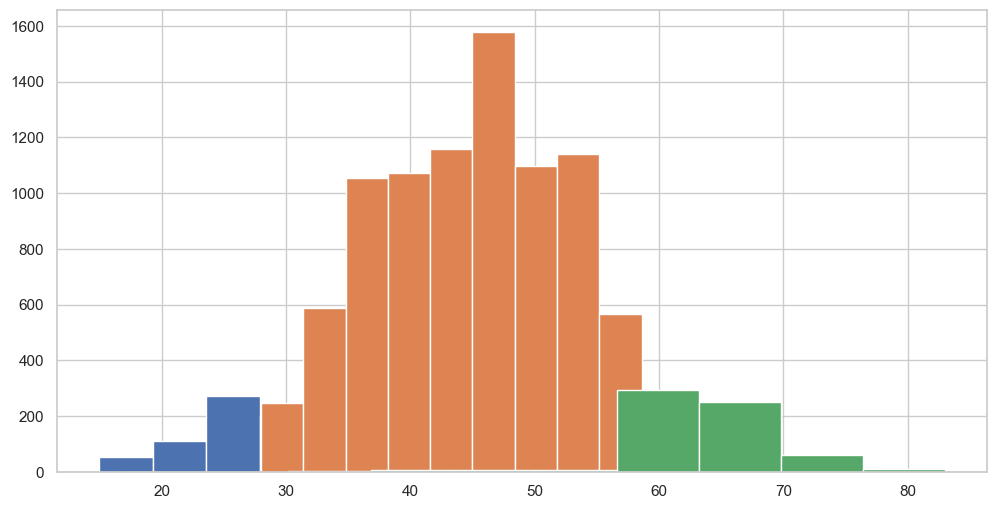

In [26]:
ab_test.query("experiment_group == 'control'").groupby('district').delivery_time.hist()

district
Central     Axes(0.125,0.11;0.775x0.77)
Purlieus    Axes(0.125,0.11;0.775x0.77)
Suburb      Axes(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

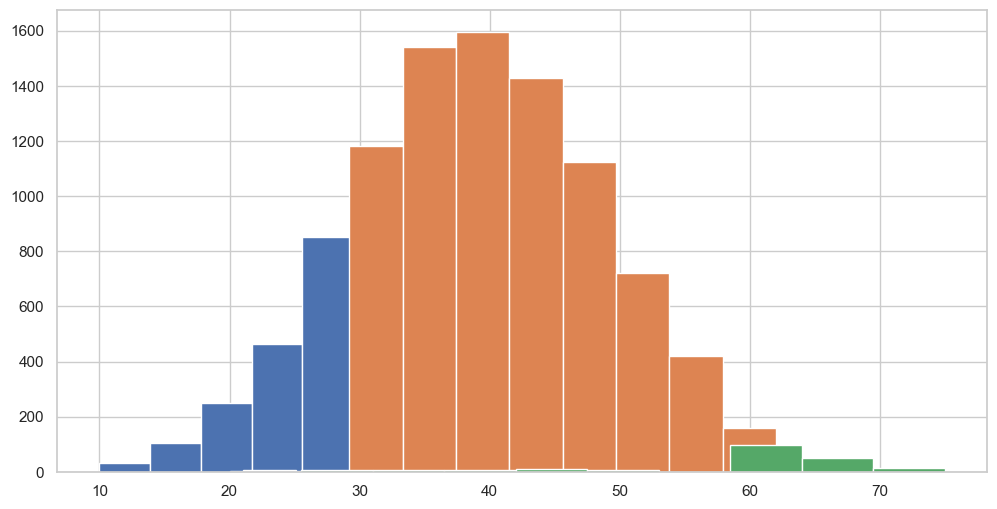

In [27]:
ab_test.query("experiment_group == 'test'").groupby('district').delivery_time.hist()

<Axes: xlabel='delivery_time', ylabel='Count'>

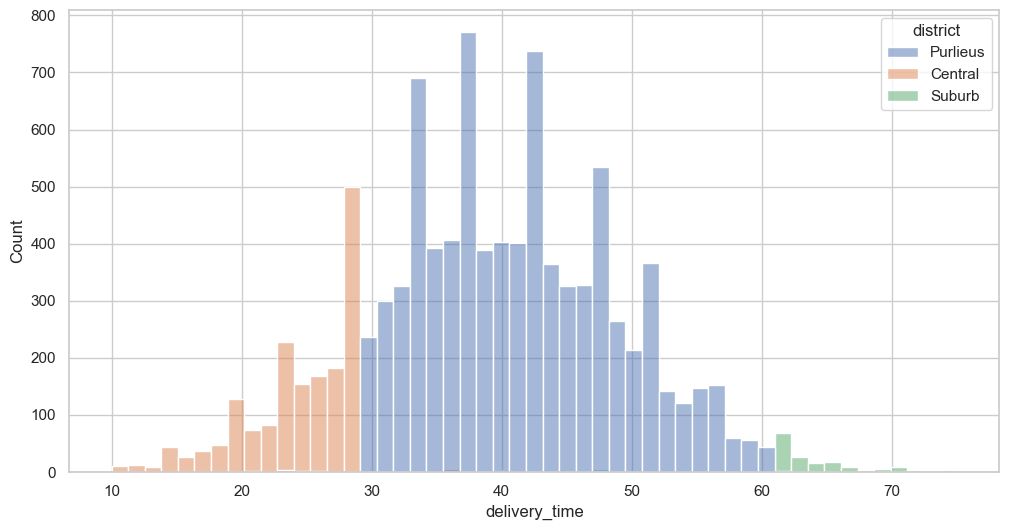

In [36]:
sns.histplot(data=ab_test.query("experiment_group == 'test'"), x = "delivery_time", hue="district")

<Axes: xlabel='delivery_time', ylabel='Count'>

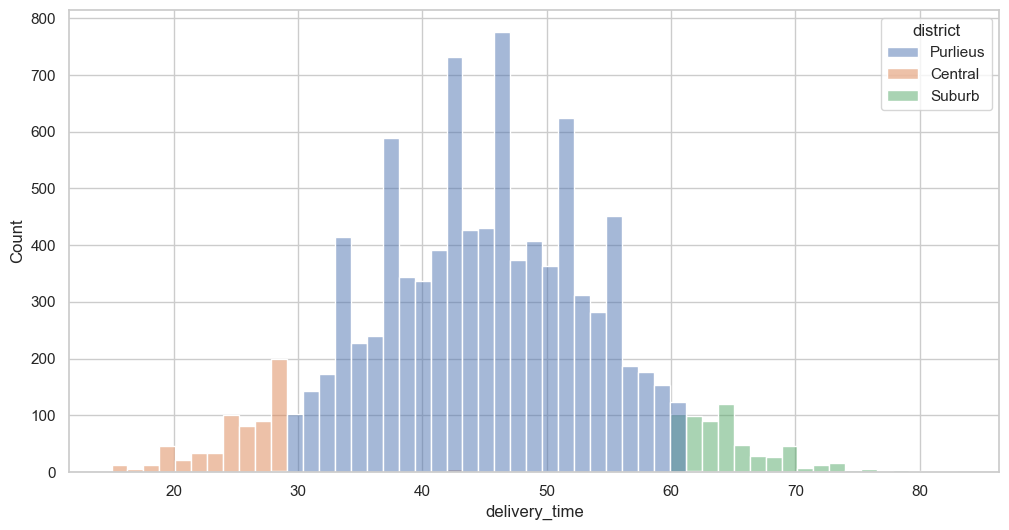

In [37]:
sns.histplot(data=ab_test.query("experiment_group == 'control'"), x = "delivery_time", hue="district")

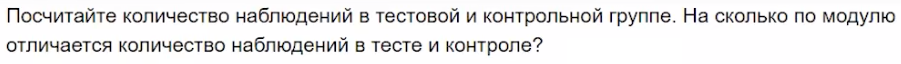

In [39]:
ab_test.groupby('experiment_group').size().

experiment_group
control    10092
test       10104
dtype: int64

In [40]:
10104-10092

12

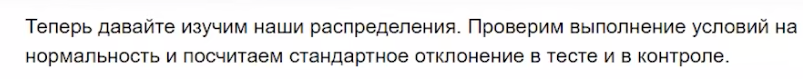

In [42]:
#стандартное отклн

ab_test.groupby('experiment_group').delivery_time.std()

experiment_group
control    9.990017
test       9.883308
Name: delivery_time, dtype: float64

In [45]:
# смотрим нормальность распределения по Шапиро

pg.normality(data=ab_test, dv='delivery_time', group='experiment_group')

C:\Users\spit\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10092.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\spit\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10104.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
experiment_group,,,
control,0.998709,2.809902e-07,False
test,0.998619,1.073905e-07,False


In [56]:
# смотрим по альтернативному тесту. method='normaltest' предназначенная для более  больших выборок. Орентировемся на это.

pg.normality(data=ab_test, dv='delivery_time', group='experiment_group', method='normaltest')

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


In [54]:
# вариант с сэмплированием
# но в среднем сэмплирование не оч хороший метод

st.shapiro(ab_test.query("experiment_group == 'control'").delivery_time.sample(1000, random_state = 17))

ShapiroResult(statistic=0.9974716381542054, pvalue=0.12392829880543466)

In [55]:
# вариант с сэмплированием

st.shapiro(ab_test.query("experiment_group == 'test'").delivery_time.sample(1000, random_state = 17))

ShapiroResult(statistic=0.9975429485383064, pvalue=0.13902241238486684)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

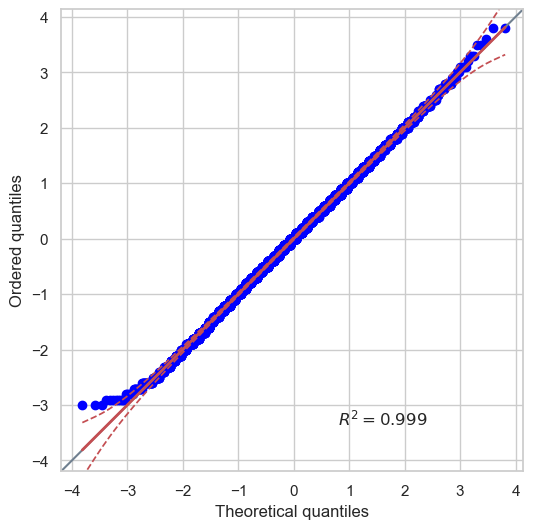

In [58]:
pg.qqplot(ab_test.query("experiment_group == 'control'").delivery_time)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

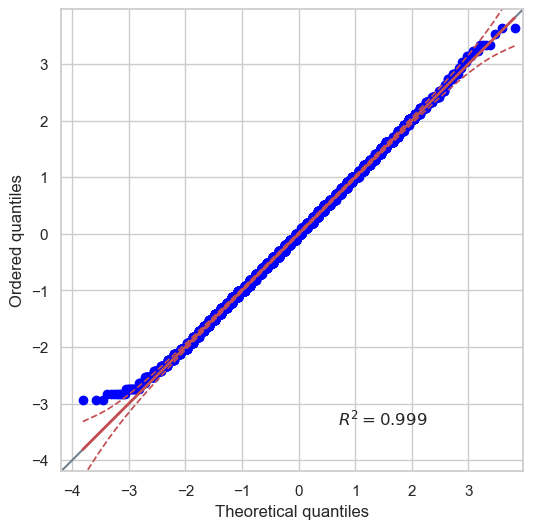

In [60]:
pg.qqplot(ab_test.query("experiment_group == 'test'").delivery_time)

Если граффик(qqplot) лежит, примерно, по 1 линии то можем сделать вывод, что группы распределены нормально 

Делаем вывод, что значения в тестовой группе распределены ненормально. В контрорльной группе распределение нормальное. \
Стандартное отклонение в: \
control    9.990017 \
test       9.883308 

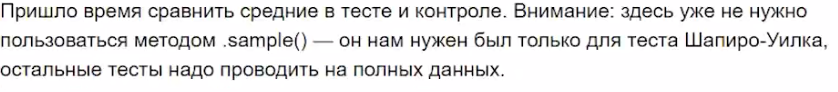

In [63]:
#scipy
st.ttest_ind( a = ab_test.query("experiment_group == 'test'").delivery_time,
              b = ab_test.query("experiment_group == 'control'").delivery_time)

TtestResult(statistic=-43.03582663183714, pvalue=0.0, df=20194.0)

In [66]:
#pingouin
pg.ttest( x = ab_test.query("experiment_group == 'test'").delivery_time,
              y = ab_test.query("experiment_group == 'control'").delivery_time)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


-----------------

In [67]:
# попробуем для сравнения
#scipy

st.mannwhitneyu( x = ab_test.query("experiment_group == 'test'").delivery_time,
              y = ab_test.query("experiment_group == 'control'").delivery_time)

MannwhitneyuResult(statistic=33985060.0, pvalue=0.0)

In [72]:
#pingouin
pg.mwu(x = ab_test.query("experiment_group == 'test'").delivery_time,
       y = ab_test.query("experiment_group == 'control'").delivery_time)


,U-val,alternative,p-val,RBC,CLES
MWU,33985060.0,two-sided,0.0,-0.333427,0.333286


-----------------

In [77]:
#Yuen t-test. Выкидывает с начала и конца определенный процент знач ений
#scipy
st.ttest_ind( a = ab_test.query("experiment_group == 'test'").delivery_time,
              b = ab_test.query("experiment_group == 'control'").delivery_time, trim=0.2)

TtestResult(statistic=-42.16055367343425, pvalue=0.0, df=12118.0)

-----------

In [79]:
#permutation t-test. Мы берем данные 2-х групп и перемешиваем много раз. Искусственно получаем распредление 0 гипотизы
st.ttest_ind( a = ab_test.query("experiment_group == 'test'").delivery_time,
              b = ab_test.query("experiment_group == 'control'").delivery_time, permutations=1000)

TtestResult(statistic=-43.03582663183714, pvalue=0.000999000999000999, df=nan)

pvalue<5 \
p-value меньше 0.05, означает, что вероятность того, что наблюдаемые результаты (или более экстремальные) могут быть получены случайным образом, если нулевая гипотеза верна, составляет менее 5%. \
Отвергаем H0: Разница между среднем временем доставки в тестовой и контрольной группе нет \
и принимаем альтернативную H1: Разница между среднем временем доставки в тестовой и контрольной группе есть

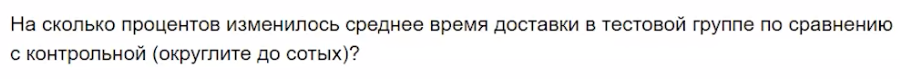

In [81]:
mean_test = ab_test.query("experiment_group == 'test'").delivery_time.mean()
mean_control = ab_test.query("experiment_group == 'control'").delivery_time.mean()

In [91]:
round(((mean_test - mean_control) / mean_control) * 100, 2)

-13.35

#### Вывод: мы выкатываем новый алгоритм, потому что среднее время доставки статистически изменилось. Ср. время доставки в тесте меньше, чем в контроле.